In [72]:
!python -V

Python 3.8.5


In [73]:
import pandas as pd

In [74]:
import pickle

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [77]:
import mlflow

#Telling mlflow we're running it with sqlite
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#Create experiment if it doesn't exist, otherwise just append to existing
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [78]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [79]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

c:\Users\akshit73\anaconda3\envs\exp-tracking-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\akshit73\anaconda3\envs\exp-tracking-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


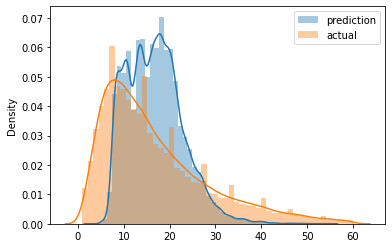

In [80]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [81]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [82]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [83]:
len(df_train), len(df_val)

(73908, 61921)

In [84]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [85]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [86]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [87]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [88]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In the below code we are trying many parameters to see what works. We should track of all what we're doing as we're modifying the file

We'll track using MLFLOW

In [41]:
with mlflow.start_run(): #all what happens in ONE RUN

    mlflow.set_tag("developer", "Akshit Miglani")
    
    #In log_param we keep information that we feel affects our model
    mlflow.log_param("train_data_path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("rmse", rmse)

Optimizing model using XGBoost and hyperopt

- We use fmin to minimise the objective function
- tpe : algorithm used to control the logic
- hp : defines ranges for objective function output
- STATUS_OK : whether the objective function has run successfully
- Trials : Track all hyper paramters

In [67]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [68]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [69]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        #Train xgboost using params on d_train dataset and use validation dataset to minimise the error
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50 #If there are 50 or more iterations without improvement on validation ERROR, then optimizaton of xgboost will stop
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status' : STATUS_OK}


Search space is the range in which we want the hyper opt to explore the hyper paramters
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/

- Max depth is a hyper paramter of XGBoost and it controls depth of the trees. We want to explore it between 4 and 100
- Learning rate: if you read the docs, the range we will explore will be between exponential(-3) -> exponential(0), so that's [0.05 to 1]
- 



In [45]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}


#Optimize "objective" function in a search space using tpe algorithm
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50, #Number of iterations of model training. 1 iteration will have 1000 rounds(if performance keeps improving without 50 consec improvement)
    trials=Trials()
)

[00:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.60533                          
[1]	validation-rmse:18.17374                          
[2]	validation-rmse:16.88405                          
[3]	validation-rmse:15.72452                          
[4]	validation-rmse:14.68346                          
[5]	validation-rmse:13.75118                          
[6]	validation-rmse:12.91752                          
[7]	validation-rmse:12.17487                          
[8]	validation-rmse:11.51229                          
[9]	validation-rmse:10.92526                          
[10]	validation-rmse:10.40479                         
[11]	validation-rmse:9.94530                          
[12]	validation-rmse:9.54029                          
[13]	validation-rmse:9.18413                          
[14]	validation-rmse:8.87167                         

### MLFLOW AUTOLOG

Now let's say we found the best model on MLFlow, now how do we save that? We get the parameters from MLFlow and run the model on that. We also plan to save the parameters to MLFLOW

https://www.mlflow.org/docs/latest/tracking.html

In [22]:
#Best paramters that we found using hyperopt
params = { 'learning_rate' : 0.5025282456558428,
'max_depth' : 11,
'min_child_weight':	0.6512069358884192,
'objective':	"reg:linear",
'reg_alpha':	0.028366066476343543,
'reg_lambda':	0.004560675852156512,
'seed':	42
}

#We're going to train the model one more time using these paramters. We also want to save this model to MLFLOW
#One way to do that is just to add that mlflow.log_params() that we have been doing
#The other way is to automate this logging process but the catch is that autologging only works for certain frameworks

#OLD WAY 

"""
with mlflow.start_run():
    mlflow.log_params(params)
    booster = xgb.train(
                params = params,
                dtrain = train,
                num_boost_round = 1000,
                evals = [(valid, "validation")],
                early_stopping_rounds = 50 #If there are 50 or more iterations without improvement on validation ERROR, then optimizaton of xgboost will stop
            )
"""

#NEW WAY

mlflow.xgboost.autolog()

booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50 #If there are 50 or more iterations without improvement on validation ERROR, then optimizaton of xgboost will stop
        )

2022/05/26 13:51:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f02c412e075b42a68b850819aaef682c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[13:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.57982
[1]	validation-rmse:8.92176
[2]	validation-rmse:7.52378
[3]	validation-rmse:7.01041
[4]	validation-rmse:6.81740
[5]	validation-rmse:6.73467
[6]	validation-rmse:6.69840
[7]	validation-rmse:6.67813
[8]	validation-rmse:6.66826
[9]	validation-rmse:6.66011
[10]	validation-rmse:6.65685
[11]	validation-rmse:6.65183
[12]	validation-rmse:6.64776
[13]	validation-rmse:6.63970
[14]	validation-rmse:6.63733
[15]	validation-rmse:6.63373
[16]	validation-rmse:6.63012
[17]	validation-rmse:6.62714
[18]	validation-rmse:6.62084
[19]	validation-rmse:6.61900
[20]	validation-rmse:6.61643
[21]	validation-rmse:6.61649
[22]	validation-rmse:6.61262
[23]	validation-rmse:6.60982
[24]	validation-rmse:6.60691
[25]	validation-rmse:6.60679
[26]	validation-rmse:6.60572
[27]	validation-rmse:6.60353
[28]	validation-rmse

2022/05/26 13:53:14 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/05/26 13:53:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\akshit73\anaconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


Saving Models to MLFlow

Log model as an artifact
- mlflow.log_artifact(local path where bin model is saved, artifact path where mlflow will save our model)

Specific framework
- mlflow.xgboost.log_model(model, artifact_path = 'models_mlflow')

In [89]:
mlflow.xgboost.autolog(disable = True)

In [91]:
mlflow.end_run()

In [92]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    #Best paramters that we found using hyperopt
    best_params = { 'learning_rate' : 0.5025282456558428,
    'max_depth' : 11,
    'min_child_weight':	0.6512069358884192,
    'objective':	"reg:linear",
    'reg_alpha':	0.028366066476343543,
    'reg_lambda':	0.004560675852156512,
    'seed':	42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
                params = best_params,
                dtrain = train,
                num_boost_round = 1000,
                evals = [(valid, "validation")],
                early_stopping_rounds = 50 #If there are 50 or more iterations without improvement on validation ERROR, then optimizaton of xgboost will stop
            )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    #If a new person wants to work with a new data, they can save the preprocessing time by using out preprocessor so this is also good to save
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")
    #Saving model
    mlflow.xgboost.log_model(booster, artifact_path = 'models_mlflow')

[00:47:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.57982
[1]	validation-rmse:8.92176
[2]	validation-rmse:7.52378
[3]	validation-rmse:7.01041
[4]	validation-rmse:6.81740
[5]	validation-rmse:6.73467
[6]	validation-rmse:6.69840
[7]	validation-rmse:6.67813
[8]	validation-rmse:6.66826
[9]	validation-rmse:6.66011
[10]	validation-rmse:6.65685
[11]	validation-rmse:6.65183
[12]	validation-rmse:6.64776
[13]	validation-rmse:6.63970
[14]	validation-rmse:6.63733
[15]	validation-rmse:6.63373
[16]	validation-rmse:6.63012
[17]	validation-rmse:6.62714
[18]	validation-rmse:6.62084
[19]	validation-rmse:6.61900
[20]	validation-rmse:6.61643
[21]	validation-rmse:6.61649
[22]	validation-rmse:6.61262
[23]	validation-rmse:6.60982
[24]	validation-rmse:6.60691
[25]	validation-rmse:6.60679
[26]	validation-rmse:6.60572
[27]	validation-rmse:6.60353
[28]	validation-rmse

Saving Random Forest Regressor

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
with mlflow.start_run():

    rf = RandomForestRegressor()  
    rf.fit(X_train, y_train)
    y_pred = rf.predict(y_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_param("model", "randomforest")
    #If a new person wants to work with a new data, they can save the preprocessing time by using out preprocessor so this is also good to save
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")
    #Saving model
    mlflow.log_artifact.log_model(rf, artifact_path = 'models_mlflow')

KeyboardInterrupt: 

Saving models gives us access to: 
- MlModel file which has all specifications
- conda.yaml
- model.xgb : size of model
- requirements.txt

## Making predictions with Models

When we click on Models tab on MLFLOW, we see two ways to make predictions
- Using Spark dataframe
- Using pandas dataframe

We can save the model using 2 different flavors
- Using Python Function
- Using Specific Framework

In [28]:
# predictions from running model
booster.predict(valid)

array([16.450424 ,  7.1195774, 13.078734 , ..., 13.771974 ,  7.1195774,
        8.110132 ], dtype=float32)

In [29]:
import mlflow
#This is our model ID
logged_model = 'runs:/b63a4351ab0d468ca9dfe215ffd3b1d7/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# We can also load a model as an XGboost framework model.  
xgboost_model = mlflow.xgboost.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
xgboost_model.predict(valid)

[15:37:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


array([16.450424 ,  7.1195774, 13.078734 , ..., 13.771974 ,  7.1195774,
        8.110132 ], dtype=float32)